In [41]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline


import warnings
warnings.filterwarnings('ignore')

#Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel('/content/drive/MyDrive/Marketing/Project/data.xlsx')

In [4]:
df.head(10)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001.0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002.0,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003.0,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004.0,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005.0,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
5,50006.0,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19
6,50007.0,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,Laptop & Accessory,2,Divorced,4,0,14.0,0.0,1.0,0.0,120.86
7,50008.0,1,NaN,Phone,1,6.0,CC,Male,3.0,3,Mobile,2,Divorced,3,1,16.0,2.0,2.0,0.0,122.93
8,50009.0,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,126.83
9,50010.0,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,Mobile,3,Single,2,0,12.0,1.0,1.0,1.0,122.93


#Exploratory data analisys and data cleaning


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5628 non-null   float64
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5628 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [6]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5628.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52814.549041,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,532.401057
std,1624.890759,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,18842.837049
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51407.750000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52814.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.330000
75%,54221.250000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.422500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,999999.000000


In [7]:
for column in df.columns:
        if column in ['PreferredLoginDevice','PreferredPaymentMode','PreferredOrderCat','MaritalStatus','Gender']:
                print("Column: {} - Unique Values: {}".format(column, df[column].unique()))
                print("="*80)

Column: PreferredLoginDevice - Unique Values: ['Mobile Phone' 'Phone' 'Computer' 'N.A.']
Column: PreferredPaymentMode - Unique Values: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Column: Gender - Unique Values: ['Female' 'Male' nan]
Column: MaritalStatus - Unique Values: ['Single' 'Divorced' 'Married' 'Widow']


<Axes: >

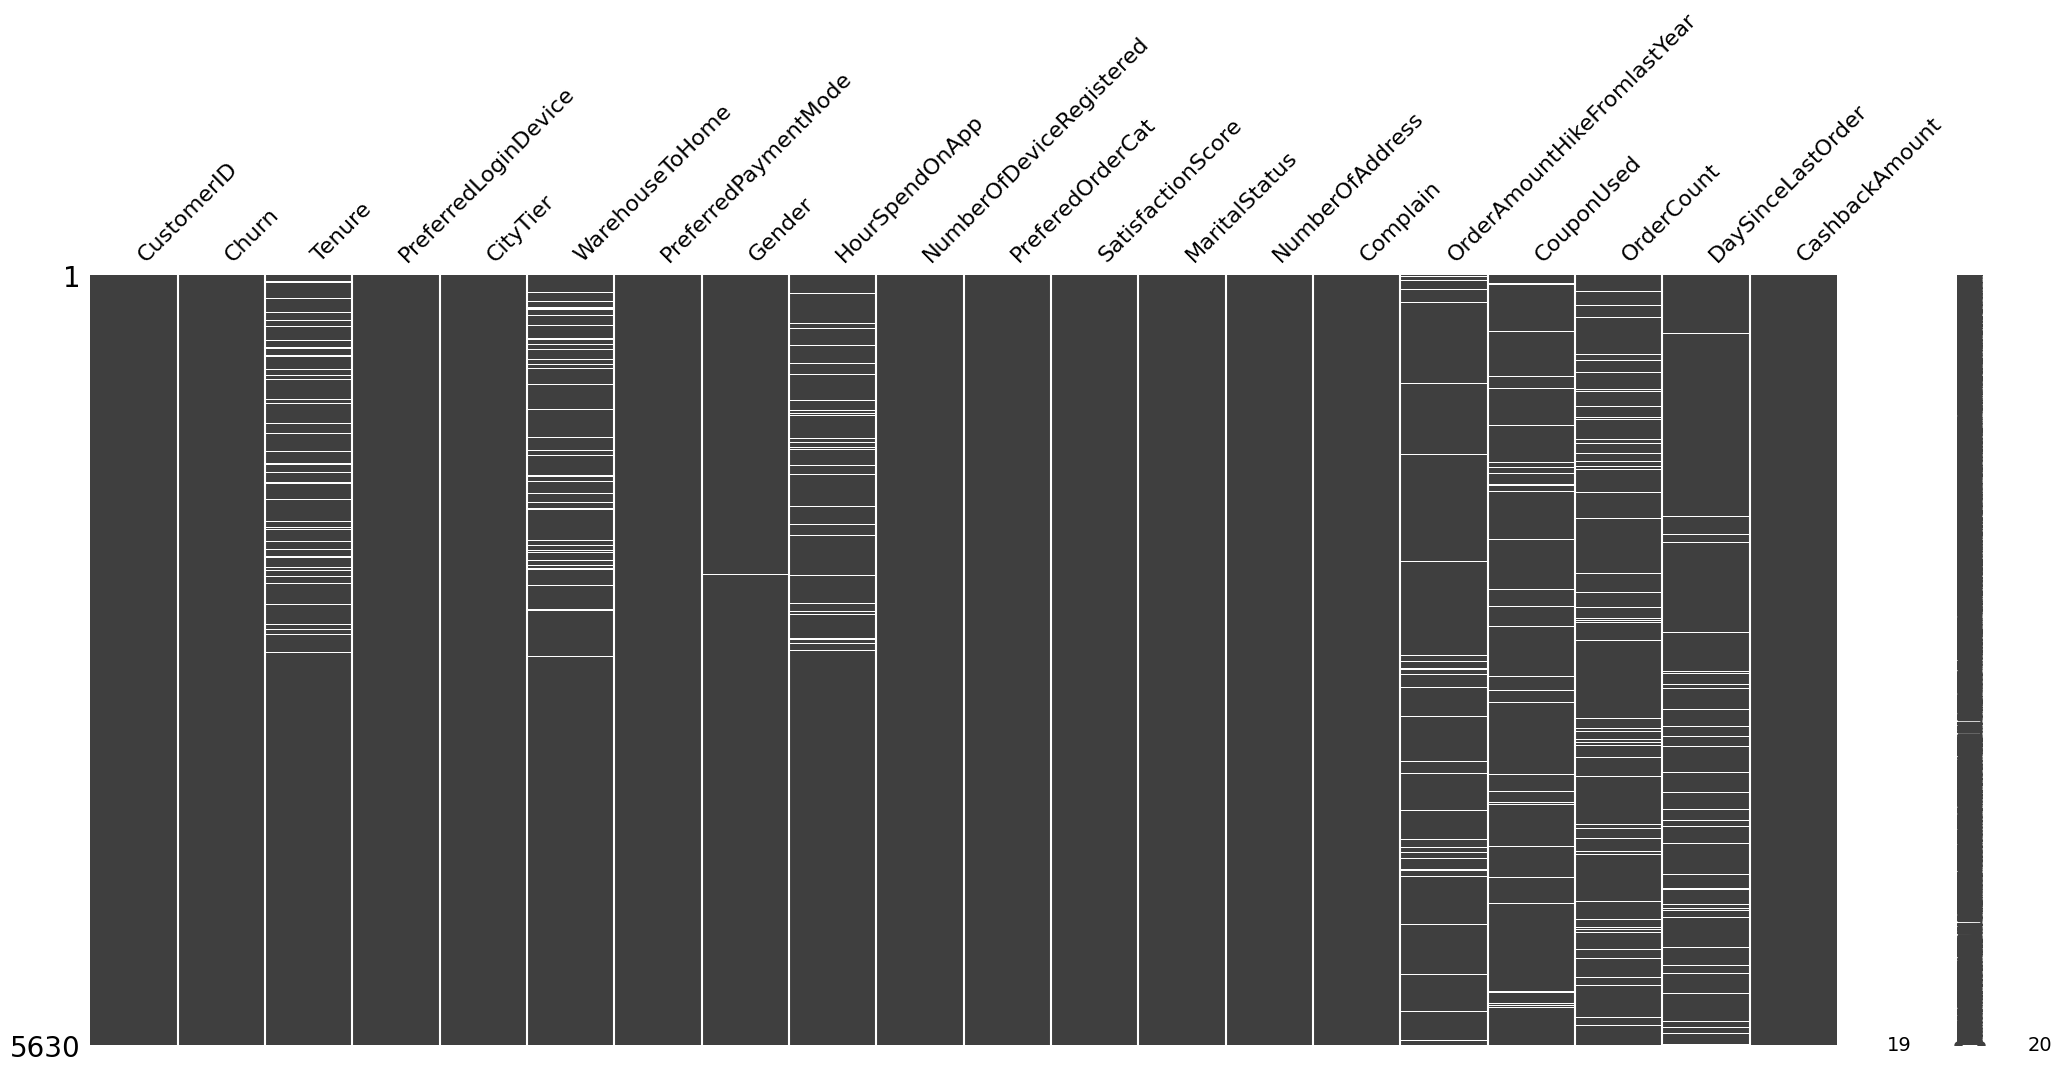

In [8]:
msno.matrix(df)

In [9]:
df.isnull().sum()

,0
CustomerID,2
Churn,0
Tenure,264
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,251
PreferredPaymentMode,0
Gender,2
HourSpendOnApp,255
NumberOfDeviceRegistered,0


The main problems with this dataset are the presence of some missing values and a possible outliers in the 'CashbackAmount' feature.
It can also be seen that the 'PreferredLoginDevice' feature has N.A. as a possible value, but this probably simply means that the customer did not specify it, so it will be treated as its own value.

#Data Cleaning

First we need to handle the various missing values.
For numerical features the missing values will be replaced with the the median, while for the categorical feature (Gender) we will use the most frequent term.
We don't need to worry about the missing values of the 'CustomerID' feature since it is just an identifier and it does not add any useful information to the dataset, thus the feature can simply be dropped.

In [10]:
df_clean = df.copy()

In [11]:
df_clean.drop('CustomerID', axis=1, inplace=True)

In [12]:
# Median for the missing numerical values
df_clean.fillna({
    'Tenure': df_clean['Tenure'].median(),
    'WarehouseToHome': df_clean['WarehouseToHome'].median(),
    'HourSpendOnApp': df_clean['HourSpendOnApp'].median(),
    'OrderAmountHikeFromlastYear': df_clean['OrderAmountHikeFromlastYear'].median(),
    'CouponUsed': df_clean['CouponUsed'].median(),
    'OrderCount': df_clean['OrderCount'].median(),
    'DaySinceLastOrder': df_clean['DaySinceLastOrder'].median(),
}, inplace=True)

# Mode for the missing categorical values
df_clean['Gender'].fillna(df_clean['Gender'].mode()[0], inplace=True)

In [13]:
df_clean.isnull().sum()

,0
Churn,0
Tenure,0
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,0
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,0
NumberOfDeviceRegistered,0
PreferedOrderCat,0


Now that we got rid of missing values we can start looking at potential outliers.

From the *describe* function we saw that the 'CashbackAmount' feature as a maximum value of 999999, probably an error. Let's investigate.

In [14]:
df_cashback_outlier = df_clean[df_clean['CashbackAmount'] > 350]
df_cashback_outlier

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
590,0,6.0,Computer,1,6.0,UPI,Female,2.0,1,Laptop & Accessory,4,Divorced,2,1,13.0,0.0,1.0,2.0,999999.0
5518,0,5.0,Mobile Phone,3,17.0,Credit Card,Female,3.0,4,Laptop & Accessory,1,Married,4,1,12.0,2.0,2.0,5.0,999999.0


Let's substitute this 2 values using again the median since they are numerical.

In [15]:
cashback_median = df_clean['CashbackAmount'].median()
df_clean.loc[df_clean['CashbackAmount'] > 350, 'CashbackAmount'] = cashback_median

Now we plot the distribution of every feature. Before doing that we need to encode the categorical features using a *LabelEncoder*, that assigns a unique integer to each different value of a column.

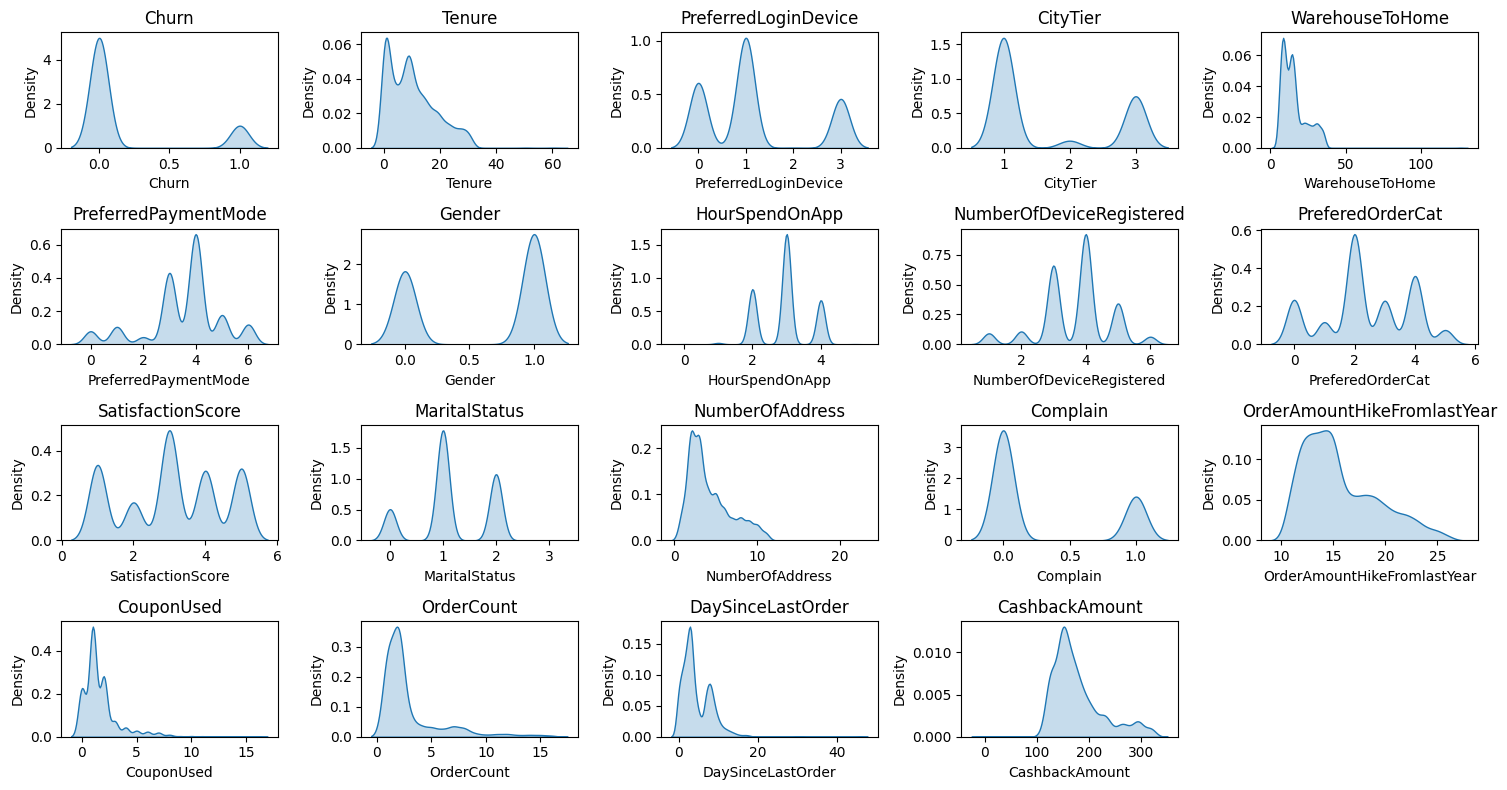

In [29]:
# Copy dataframe and encode string (object) features
df_encoded = df_clean.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

num_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns
n = len(num_features)

cols = 5
rows = math.ceil(n / cols)

fig = plt.figure(figsize=(cols * 3, rows * 2))
for i, col in enumerate(num_features):
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.kdeplot(df_encoded[col], fill=True, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.set_title(f"{col}")

plt.tight_layout()
plt.show()


Now let's check the correlation of the features with the churn rate using a correlation heatmap, a visualization tool that allows to identify patterns and relationships between variables. We are interested of the correlation of our target feature (Churn) with the others.


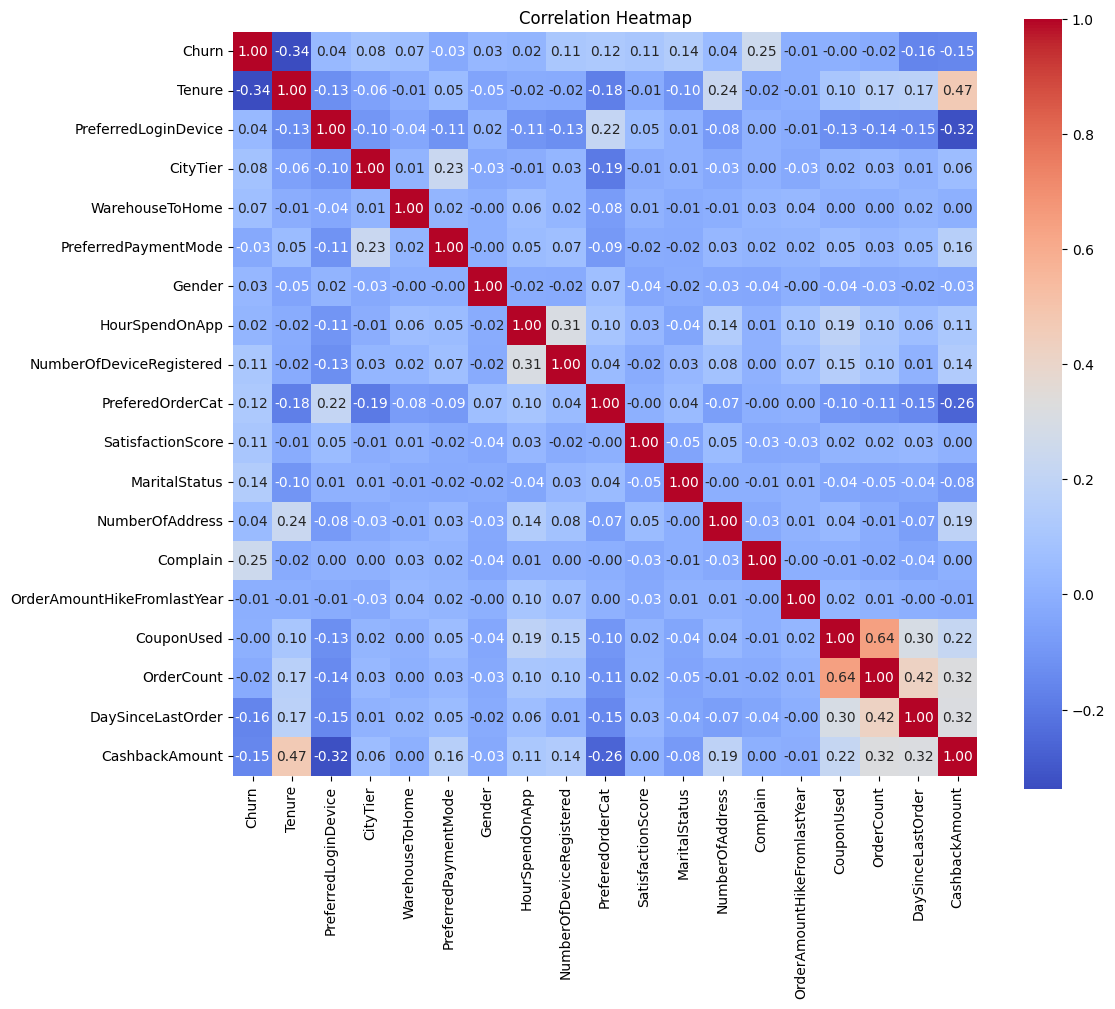


Correlation of features with 'Churn':
Churn                          1.000000
Complain                       0.250188
MaritalStatus                  0.139453
PreferedOrderCat               0.118922
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
CityTier                       0.084703
WarehouseToHome                0.069544
NumberOfAddress                0.043931
PreferredLoginDevice           0.038957
Gender                         0.029103
HourSpendOnApp                 0.018816
CouponUsed                    -0.001430
OrderAmountHikeFromlastYear   -0.007075
OrderCount                    -0.024038
PreferredPaymentMode          -0.026519
CashbackAmount                -0.154089
DaySinceLastOrder             -0.155871
Tenure                        -0.337831
Name: Churn, dtype: float64


In [27]:
# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

# Identify features with high correlation with the target ('Churn')
correlation_with_target = corr_matrix['Churn'].sort_values(ascending=False)
print("\nCorrelation of features with 'Churn':")
print(correlation_with_target)

We can derive some preliminary insights from this heatmap:

**Strongest Negative Correlations with Churn**
*   Tenure (-0.34): Longer-tenured customers are less likely to churn. This suggests customer loyalty increases over time.
*   DaySinceLastOrder (-0.16): As expected, customers who recently placed an order are less likely to churn.
*   CashbackAmount (-0.15): Greater cashback received correlates with lower churn, suggesting that monetary incentives have a retention effect.

**Strongest Positive Correlations with Churn**
*   Complain (0.25): Customers who have complained are more likely to churn. Because of this working towards decreasing the complaint rate should be the top priority
*   MaritalStatus (0.14): A weak positive correlation suggests certain marital statuses might have a slight tendency toward churn.
*   PreferedOrderCat (0.12): The category of preferred orders has a small positive relationship with churn, indicating some product categories may be linked with lower loyalty.




# Model Selection

Now it's time to generate the train and test sets.
Of course the target feature will be 'Churn'.

In [22]:
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42, shuffle = True)


What we have here is a binary classification task.
The techniques most suitable for this are: logistic regression, random forest and gradient boosting. Especially this last one, due to models like XGBoost and Catboost that can work with categorical features without needing to encode them.

##Logistic Regression

Logistic regression can't work with categorical features, so first let's transform them into one-hot vectors.
While we are at it we can also scale the numerical features, to avoid the domination of the ones with higher mean values.

In [31]:
logistic_transformation = ColumnTransformer(transformers=[
    ('numeric', StandardScaler(), numerical_cols),
    ('categorical', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), categorical_cols),
    ],
remainder='passthrough',
verbose_feature_names_out=False,
sparse_threshold=0
)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', logistic_transformation),
    ('classifier', LogisticRegression())
])

# Parameter grid (only for the classifier step)
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [500, 1000]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Accuracy: 0.8880994671403197
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       936
           1       0.74      0.52      0.61       190

    accuracy                           0.89      1126
   macro avg       0.82      0.74      0.77      1126
weighted avg       0.88      0.89      0.88      1126



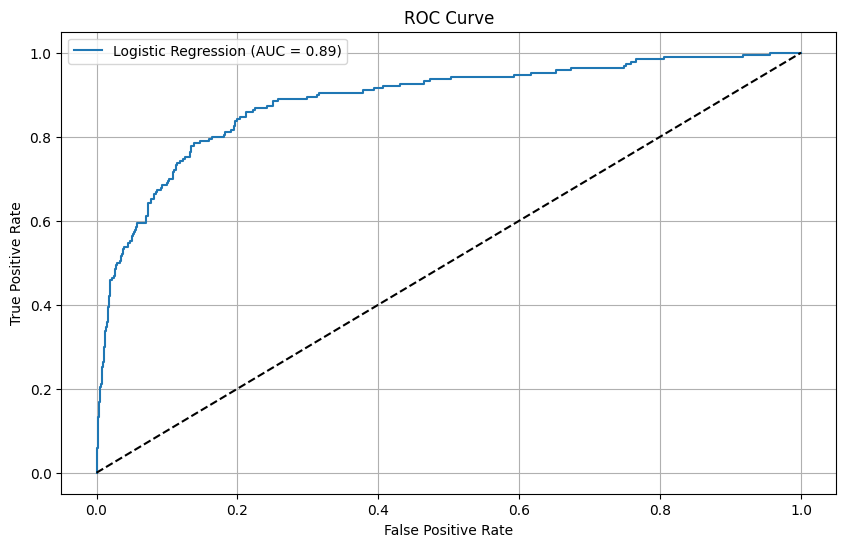

In [32]:
def add_roc_plot(model, test_x, test_y, legend_text):
    # Get predicted probabilities for class 1
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
    auc = roc_auc_score(test_y, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{legend_text} (AUC = {auc:.2f})")
    plt.legend()

# Example usage for logistic regression pipeline
models_list = [best_lr_model]  # Or whatever your best logistic model variable is called
model_names = ['Logistic Regression']

plt.figure(figsize=(10, 6))
[add_roc_plot(model, X_test, y_test, name) for model, name in zip(models_list, model_names)]

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


##Random Forest

Random Forests are not sensitive to feature scales, so we only need to encode the categorical features.

In [33]:
# Define the preprocessing transformer
forest_transformation = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    sparse_threshold=0
)

# Define the full pipeline with Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', forest_transformation),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced']
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model prediction and evaluation
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Accuracy: 0.9857904085257548
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.99      0.92      0.96       190

    accuracy                           0.99      1126
   macro avg       0.99      0.96      0.97      1126
weighted avg       0.99      0.99      0.99      1126



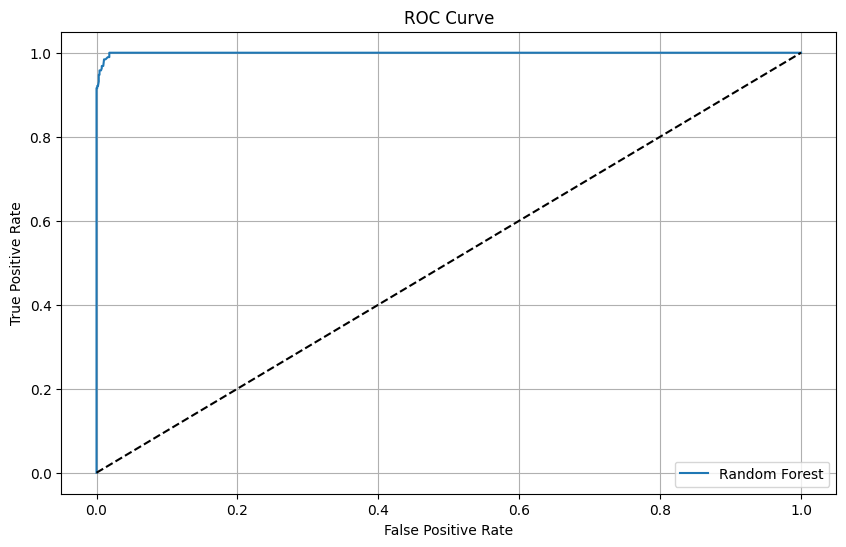

In [35]:
def add_roc_plot(model, test_x, test_y, legend_text):
    # If it's a pipeline, it already includes preprocessing
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
    plt.plot(fpr, tpr, label=legend_text)
    plt.legend()

# Use your trained Random Forest pipeline
models_list = [best_rf_model]
model_names = ['Random Forest']

plt.figure(figsize=(10, 6))
[add_roc_plot(model, X_test, y_test, legend_text) for model, legend_text in zip(models_list, model_names)]

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


##XGBOOST

The only preprocessing step needed with XGBoost is converting the features with 'object' dtype to 'category'.

In [49]:
categorical_cols = (X_train.dtypes[X_train.dtypes == 'object'].index)

In [50]:
for col in categorical_cols:
    X_train[col]=X_train[col].astype("category")

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4504 entries, 1787 to 5140
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Tenure                       4504 non-null   float64 
 1   PreferredLoginDevice         4504 non-null   category
 2   CityTier                     4504 non-null   int64   
 3   WarehouseToHome              4504 non-null   float64 
 4   PreferredPaymentMode         4504 non-null   category
 5   Gender                       4504 non-null   category
 6   HourSpendOnApp               4504 non-null   float64 
 7   NumberOfDeviceRegistered     4504 non-null   int64   
 8   PreferedOrderCat             4504 non-null   category
 9   SatisfactionScore            4504 non-null   int64   
 10  MaritalStatus                4504 non-null   category
 11  NumberOfAddress              4504 non-null   int64   
 12  Complain                     4504 non-null   int64   
 13  Order

In [52]:
# Base model
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Find best model
best_xgb_model = grid_search.best_estimator_

In [54]:
for col in categorical_cols:
    X_test[col]=X_test[col].astype("category")

In [68]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1126 entries, 4006 to 1314
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Tenure                       1126 non-null   float64 
 1   PreferredLoginDevice         1126 non-null   category
 2   CityTier                     1126 non-null   int64   
 3   WarehouseToHome              1126 non-null   float64 
 4   PreferredPaymentMode         1126 non-null   category
 5   Gender                       1126 non-null   category
 6   HourSpendOnApp               1126 non-null   float64 
 7   NumberOfDeviceRegistered     1126 non-null   int64   
 8   PreferedOrderCat             1126 non-null   category
 9   SatisfactionScore            1126 non-null   int64   
 10  MaritalStatus                1126 non-null   category
 11  NumberOfAddress              1126 non-null   int64   
 12  Complain                     1126 non-null   int64   
 13  Order

In [56]:
y_pred = best_xgb_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.9928952042628775
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       936
           1       0.98      0.97      0.98       190

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



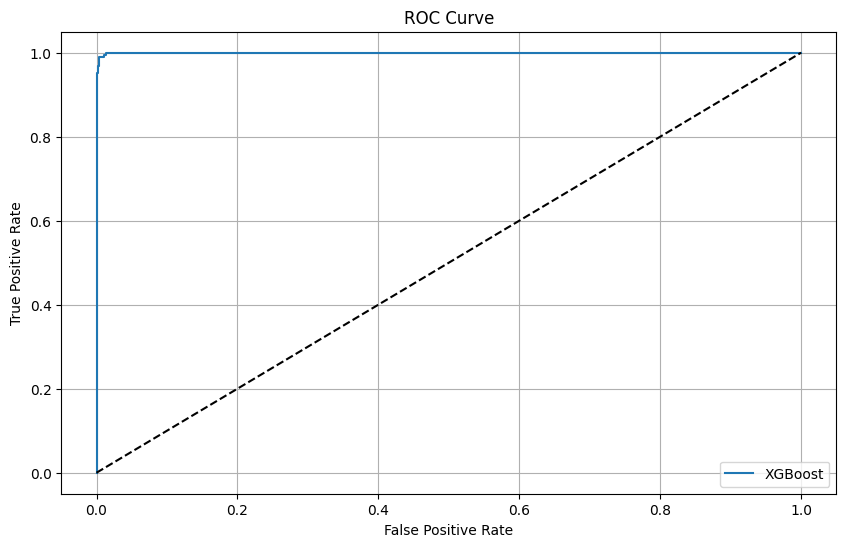

In [58]:
def add_roc_plot(model, test_x, test_y, legend_text):
    # If it's a pipeline, it already includes preprocessing
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
    plt.plot(fpr, tpr, label=legend_text)
    plt.legend()

# Use your trained Random Forest pipeline
models_list = [best_xgb_model]
model_names = ['XGBoost']

plt.figure(figsize=(10, 6))
[add_roc_plot(model, X_test, y_test, legend_text) for model, legend_text in zip(models_list, model_names)]

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


##CatBoost

For CatBoost it is only necessary to specify which features are categorical when defining the model.

In [46]:
# Model definition
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    random_state=42,
    cat_features=[1, 4, 5, 8, 10] # Categorical features
)

# Define hyperparameter grid
param_grid = {
    'iterations': [100, 300],
    'depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]  # Affects how categorical splits are made
}

grid_search = GridSearchCV(cat_model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model using X_train and y_train directly
grid_search.fit(X_train, y_train)

# Find best model
best_cat_model = grid_search.best_estimator_

# Predict using the best model
# Pass X_test directly to the best_cat_model for prediction
preds_class = best_cat_model.predict(X_test)
preds_proba = best_cat_model.predict_proba(X_test)

0:	learn: 0.5840699	total: 67.5ms	remaining: 20.2s
1:	learn: 0.5181401	total: 77ms	remaining: 11.5s
2:	learn: 0.4491879	total: 98ms	remaining: 9.71s
3:	learn: 0.3906674	total: 118ms	remaining: 8.71s
4:	learn: 0.3416775	total: 139ms	remaining: 8.21s
5:	learn: 0.3235160	total: 143ms	remaining: 7.03s
6:	learn: 0.2930489	total: 163ms	remaining: 6.84s
7:	learn: 0.2677945	total: 184ms	remaining: 6.71s
8:	learn: 0.2438363	total: 205ms	remaining: 6.63s
9:	learn: 0.2267961	total: 226ms	remaining: 6.55s
10:	learn: 0.2164282	total: 271ms	remaining: 7.11s
11:	learn: 0.2028868	total: 292ms	remaining: 7s
12:	learn: 0.1920476	total: 312ms	remaining: 6.89s
13:	learn: 0.1861204	total: 332ms	remaining: 6.78s
14:	learn: 0.1773924	total: 353ms	remaining: 6.71s
15:	learn: 0.1695256	total: 373ms	remaining: 6.61s
16:	learn: 0.1629816	total: 393ms	remaining: 6.55s
17:	learn: 0.1560744	total: 415ms	remaining: 6.5s
18:	learn: 0.1504539	total: 435ms	remaining: 6.43s
19:	learn: 0.1446422	total: 456ms	remaining: 6

In [47]:
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'border_count': 32, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Accuracy: 0.9857904085257548
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.99      0.92      0.96       190

    accuracy                           0.99      1126
   macro avg       0.99      0.96      0.97      1126
weighted avg       0.99      0.99      0.99      1126



#Models evaluation

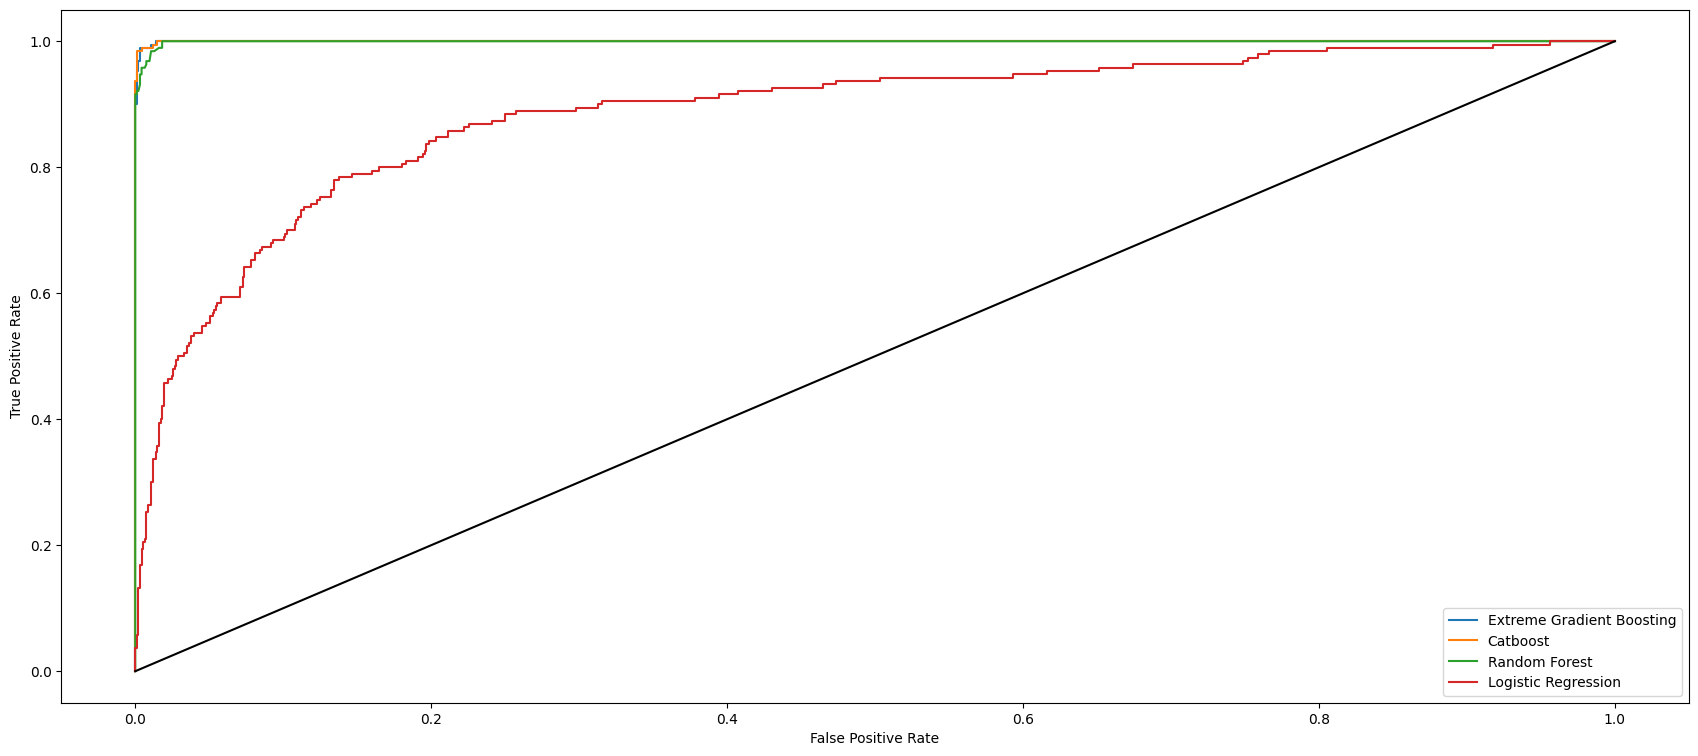

In [61]:
models_list = [best_xgb_model, best_cat_model, best_rf_model, best_lr_model]
model_names = ['Extreme Gradient Boosting', 'Catboost', 'Random Forest', 'Logistic Regression']

plt.figure(figsize=(21, 9))
[add_roc_plot(model, X_test, y_test, legend_text) for model, legend_text in zip(models_list, model_names)]

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k-")
plt.show()

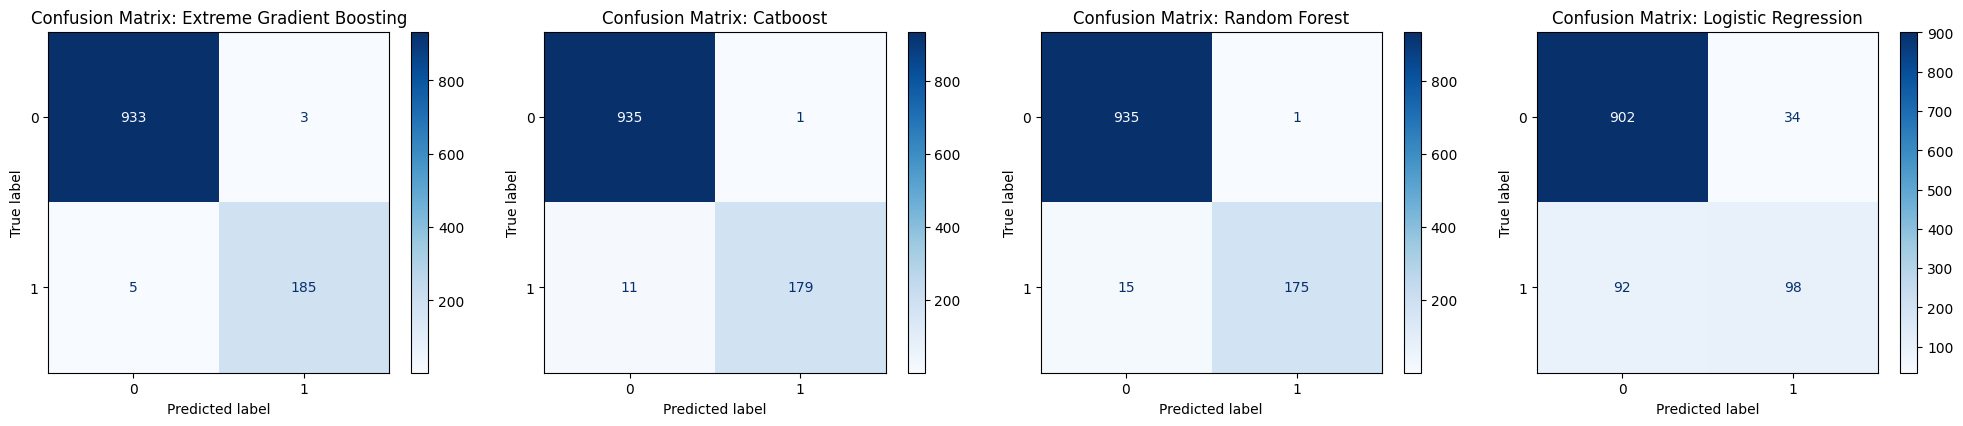

In [66]:
n_models = len(models_list)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

for ax, model, name in zip(axes, models_list, model_names):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {name}')
    ax.grid(False)

plt.tight_layout()
plt.show()


In [62]:
list_scores = [roc_auc_score, recall_score, precision_score, accuracy_score]
calc_scores = []
def compute_scores(model, x_test, y_test, scores):
    return [round(score(y_test, model.predict(x_test)), 2) for score in scores]

[calc_scores.append(compute_scores(model, X_test, y_test, list_scores)) for model in models_list]

score_names = ['roc_auc', 'recall', 'precision', 'accuracy']
scores_df = pd.DataFrame(calc_scores, columns=score_names, index=model_names)

scores_df

,roc_auc,recall,precision,accuracy
Extreme Gradient Boosting,0.99,0.97,0.98,0.99
Catboost,0.97,0.94,0.99,0.99
Random Forest,0.96,0.92,0.99,0.99
Logistic Regression,0.74,0.52,0.74,0.89


Except for the simplest model, *Logistic Regression*, the others all yield comparable results, but the best one overall is *Extreme Gradient Boosting*.
Let's visualize and try to explain the features with the most impact on the outcome using *SHAP*.

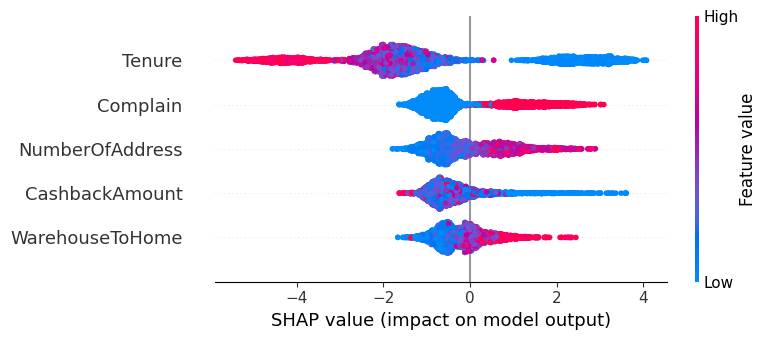

In [87]:
import shap
X_shap = X.copy()

# Encode object-type columns (if any)
for col in X_shap.select_dtypes(include='object').columns:
    X_shap[col] = LabelEncoder().fit_transform(X_shap[col])

shap.initjs()

explainer = shap.TreeExplainer(best_xgb_model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, max_display=5)


This plot mostly confirms what was seen on the correlation heatmap:

*   Tenure is the most influential feature. Low tenure tends to push the model toward predicting churn. High tenure pushes the prediction toward retention.
*   If a customer has complained, it pushes predictions toward churn.
*   More addresses might indicate instability and increase churn risk.
*   Low cashback amounts increases churn likelihood.
*   Longer delivery distances are associated with dissatisfaction, increasing churn likelyhood.



#Key Takeaways

*   Prioritize loyalty efforts for new customers.

*   Rapidly resolve customer complaints since they are strong churn signals.

*   Use cashback and other personalized offers to retain at-risk segments.

*   Improve delivery times when possible to reduce dissatisfaction from longer distances.

*   Pay attention to patterns like frequent address changes or preferred product categories. These can help identify which customers may be at a higher risk of churning.